# Introduction
In this notebook, we will be building a Graph Convolutional Network on the `ogbn-arxiv` citation network and trying to match performance to the [OGB Leaderboard for Node Property Prediction](https://ogb.stanford.edu/docs/leader_nodeprop/#ogbn-arxiv).  Once we can faithfully re-create this, we will move on to implementing improvements and tweaks found in the [Bag of Tricks for Node Classification with Graph Neural Networks](https://arxiv.org/abs/2103.13355) paper.

# What you need to do
## Basics 
With few exceptions, you only need to implement the PyTorch/DGL model code and everything else is written to train and evaluate.  Sections you need to write code for will be marked with a "TODO" comment.  As a first pass, do not modify any of the code *except where indicated* so that troubleshooting will be easier if you run into problems.

## Improvements
Once you have a correct implementation and can match leaderboard performance, we can move on to experimentation.  In this section, we will implement a few ideas from the ["Bag of Tricks"](https://arxiv.org/abs/2103.13355) paper, which should give improvements above baseline GCN and move you several positions up the leaderboard.  

## Statistics
At the end of each section, there is code for repeating your experiment 10 times to collect statistics on performance since any single run might be (un)lucky and give unrepresentative performance.  This also allows us to make apples-to-apples comparisons to the leaderboard.  However, this process takes significant time.  Feel free to skip these cells until after you've finished implementing all sections and then you can collect statistics e.g., overnight if you wish.

## Extra Credit 
A great way to learn is to 1) read other peoples' code and 2) tinker.  If you want to maximize your learning, the Extra Credit section will provide a few directions for further exploration.  As part of this, it's recommended you find another submission on the OGB Leaderboard and try to re-create its submission.  This will likely involve reading the paper and code, which is great practice.  If you do something interesting and novel, we'll kindly host it in a public repo as an example of your glory (if you wish).

***

# Boilerplate

In [1]:
import sys
import os
import math
from copy import deepcopy
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import stats

import torch as th
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cuda_version = th.version.cuda
print(f"Torch version: {th.__version__}.  CUDA version: {cuda_version}")

Torch version: 2.0.0.  CUDA version: None


In [3]:
# This will attempt to figure out the right DGL package to install, 
# but please verify that it is correct for your environment!
# Follow instructions at https://www.dgl.ai/pages/start.html
DGL_PKG = f'dgl-cu{cuda_version.replace(".", "")}' if cuda_version else 'dgl'
DGL_PKG

'dgl'

In [4]:
# Verify command with DGL documentation, and then install DGL
!{sys.executable} -m pip install {DGL_PKG} -f https://data.dgl.ai/wheels/repo.html

Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.dgl.ai/wheels/repo.html


In [5]:
!{sys.executable} -m pip install ogb

Defaulting to user installation because normal site-packages is not writeable


In [6]:
os.environ['DGLBACKEND'] = 'pytorch'
import dgl
from dgl.nn import GraphConv
from ogb.nodeproppred import DglNodePropPredDataset, Evaluator

In [7]:
device = 'cuda' if th.cuda.is_available() else 'cpu'
device = th.device(device)
device

device(type='cpu')

## Helper functions

In [8]:
def plot_losses(train_losses, val_losses, log=False):
    """
    Plots train/validation loss curves vs training epoch
    """
    fig, ax = plt.subplots()

    ax.plot(train_losses, label='Train')
    ax.plot(val_losses, label='Val')
    ax.set(xlabel='Epoch', ylabel='CrossEnt')
    if log:
        ax.set_yscale('log')
    ax.legend()
    ax.grid()
    
def train(g, labels, split_idx, model, epochs, evaluator, 
          device, save_path, loss_fn=F.cross_entropy, lr=0.01, es_criteria=5, verbose=False):
    """
    A standard interface for model training.  Should be no reason to change this unless you 
    want to add improvements (e.g., learning rate scheduler).
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_val_acc = 0
    best_test_acc = 0
    train_losses = list()
    val_losses = list()

    features = g.ndata['feat']
    
    train_mask = split_idx['train'].to(device)
    val_mask = split_idx['valid'].to(device)
    test_mask = split_idx['test'].to(device)
    es_iters = 0
    
    for e in range(1, epochs+1):
        
        train_loss, val_loss = train_step(
            model, g, features, labels, train_mask, val_mask, optimizer, loss_fn
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Compute accuracy on training/validation/test
        train_acc, val_acc, test_acc = test(model, g, labels, split_idx, evaluator)

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc
            th.save(model.state_dict(), save_path)
            es_iters = 0
        else:
            es_iters += 1
            

        if e % 50 == 0 and verbose:
            print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
                e, train_loss, val_acc, best_val_acc, test_acc, best_test_acc))
            
        if es_iters >= es_criteria:
            print(f"Early stopping at {e} epochs")
            break
            
    return np.array(train_losses), np.array(val_losses)

def train_step(model, g, features, labels, train_mask, val_mask, optimizer, loss_fn):
    """
    A single training step
    """
    model.train()

    optimizer.zero_grad()
    logits = model(g, features)
    loss = loss_fn(logits[train_mask], labels[train_mask])
    loss.backward()
    optimizer.step()
    
    with th.no_grad():
        val_loss = loss_fn(logits[val_mask], labels[val_mask])

    return loss.item(), val_loss.item()

@th.no_grad()
def test(model_cp, g, labels, split_idx, evaluator, best_path=None):
    """
    Executes the OGB Evaluator to return accuracy for 
    the train, valid and test sets.  If passed in a model file path, 
    loads the parameters from that file, otherwise uses the model object
    passed in.
    """
    model = deepcopy(model_cp)
    
    if best_path is not None:
        model.load_state_dict(th.load(best_path))
        
    model.eval()
    
    features = g.ndata['feat']
    logits = model(g, features)
    y_pred = logits.argmax(1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': labels[split_idx['train']].reshape((-1,1)),
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': labels[split_idx['valid']].reshape((-1,1)),
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': labels[split_idx['test']].reshape((-1,1)),
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    return train_acc, valid_acc, test_acc

def characterize_performance(model, g, labels, split_idx, evaluator, best_path, verbose=False):
    """
    Gets performance and compares to the Leaderboard performance for GCN.
    Optionally (`verbose=True`) will put the performance in context with the variation
    reported on the Leaderboard and indicate whether performance is above/below 
    1-standard deviation from the mean, as given by Leaderboard.
    """
    train_acc, val_acc, test_acc = test(model, g, labels, split_idx, evaluator, best_path)
    print(
        f"Leaderboard:  Test Acc={test_acc_lb} +/- {test_acc_lb_var}, Val Acc={val_acc_lb} +/- {val_acc_lb_var}\n"
        f"Yours:        Test Acc={test_acc:.4f},            Val Acc={val_acc:.4f}\n"
    )

    val_lb = val_acc_lb - val_acc_lb_var
    val_ub = val_acc_lb + val_acc_lb_var
    
    if verbose:
        if not val_acc >= val_lb:
            print(
                f"Validation performance is worse than LB.  Expected lower bound of {val_lb:.4f}, but got {val_acc:.4f}.")
        elif val_acc > val_ub:
            print(
                f"Validation performance is better than LB.  Expected upper bound of {val_ub:.4f}, but got {val_acc:.4f}.")
        else: 
            print(
                f"Validation performance is in the expected range of {val_lb} - {val_ub}."
            )
    
    test_lb = test_acc_lb - test_acc_lb_var
    test_ub = test_acc_lb + test_acc_lb_var
    if verbose:
        if not test_acc >= test_lb:
            print(
                f"Test performance is worse than LB.  Expected lower bound of {test_lb:.4f}, but got {test_acc:.4f}.")

        elif test_acc > test_ub:
            print(
                f"Test performance is better than LB.  Expected upper bound of {test_ub:.4f}, but got {test_acc:.4f}.")
        else:
            print(f"Test performance is in the expected range of {test_lb} - {test_ub}.")
        
    return val_acc, test_acc

def norm_plot(curves, title):
    """
    Plots normal distribution curves
    curves: list of tuples like: (mu, sigma, label)
    """
    fig, ax = plt.subplots()
    for mu, sigma, label in curves:
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        ax.plot(x, stats.norm.pdf(x, mu, sigma), label=label)
    
    ax.set_title(title)
    ax.legend()
    
def get_experiment_stats(model_cls, model_args, train_args, n_experiments=10):
    """
    Runs an experiment multiple times to get a measure of variation
    """
    results = dict()
    for i in range(n_experiments):
        model = model_cls(**model_args).to(train_args['device'])
        print(f"Starting training for experiment {i+1}")
        # Add experiment number to model save_path
        train_args_cp = deepcopy(train_args)
        save_path, file_ext = train_args_cp.pop('save_path').split('.')
        save_path_mod = f"{save_path}_{i}.{file_ext}"
        
        train_losses, val_losses = train(model=model, save_path=save_path_mod, **train_args_cp)
        val_acc, test_acc = characterize_performance(
            model, train_args['g'], train_args['labels'], train_args['split_idx'], 
            train_args['evaluator'], save_path_mod, train_args.get('verbose', False))
        
        results[i] = dict(val_acc=val_acc, test_acc=test_acc)
        print("Training complete\n")
        
    df_stats = pd.DataFrame(results).T.agg(['mean', 'std'])
    return df_stats

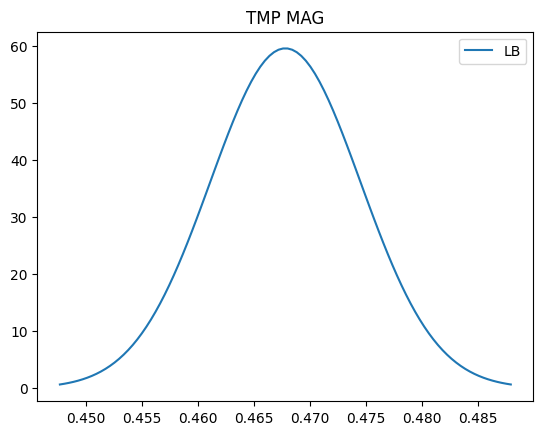

In [9]:
norm_plot([(0.4678, 0.0067, 'LB')], 'TMP MAG')

# Basics
## Get OGB dataset and GCN leaderboard performance
We will use the `ogb` python package to download the data, give us the correct train/validation/test splits for proper comparison and an `Evaluator` to make sure performance is measured appropriately.  

In [10]:
dataset = DglNodePropPredDataset(name = "ogbn-arxiv", root = 'dataset/')

In [11]:
# Values from the OGB leaderboard of GCN, submitted May 1, 2020
val_acc_lb, val_acc_lb_var, test_acc_lb, test_acc_lb_var = 0.7300, 0.0017, 0.7174, 0.0029
evaluator = Evaluator(name = "ogbn-arxiv")

In [12]:
# Extract split indices, DGL graph and labels
split_idx = dataset.get_idx_split()
g = dataset.graph[0]
labels = dataset.labels.flatten().to(device)

### Important 
Add reverse edges and self-loops to the graph, or performance will severely suffer!  By default, the edges are *directed*, meaning an edge from node A -> B is not an edge from node B -> A.  We need to add these reverse edges.  Also, for GCN we need to add an edge from every node to itself (i.e., "self-loops").  

**Caution**:  Adding self-loops before adding reverse edges can cause unintuitive behavior that duplicates the self-edges.  Specifically, using the `add_reverse_edges` function ([docs](https://docs.dgl.ai/en/0.8.x/generated/dgl.add_reverse_edges.html)) in DGL prior to version 0.8 will "reverse" the self-loops and cause duplicates.  Starting in version 0.8, you can specify the `exclude_self` argument (True by default) to ignore self-loops when reversing.  You can also use the `to_bidirected` function ([docs](https://docs.dgl.ai/en/0.8.x/generated/dgl.to_bidirected.html)) to avoid this pitfall.  

In [13]:
# TODO
#ndata = g.ndata
g = dgl.to_bidirected(g,copy_ndata=True)
g = dgl.add_self_loop(g)
g.num_edges()

2484941

In [14]:
# If this fails, you have a mistake
assert g.num_edges() == 2484941, "Number of edges isn't correct!  Make sure self-loop and reverse edges are added."
# If this fails, you have duplicate edges
assert g.is_multigraph is False
# If this fails and you used `to_bidirected`, check the documentation for this function
assert 'feat' in g.ndata, "Node features are missing.  Did you drop them?"

In [15]:
g = g.to(device)

## Define GCN Model
To match the performance on the Leaderboard, we'll need to implement our model using the same architecture as the submission.  Note that [their implementation](https://github.com/snap-stanford/ogb/blob/master/examples/nodeproppred/arxiv/gnn.py#L14) is using PyTorch Geometric, not DGL.  However, we can observe these key elements, which you'll need to reproduce:
1. Graph Convolution layer
    - Exploring the possible arguments (e.g., normalization, if a bias is included, "improved"...etc) could raise many questions, but the defaults of optional arguments between DGL and Geometric should give matching implementations (as of this writing).
2. Batch Normalization layer
    - Not applied to the final output layer
3. ReLU activation
    - Not applied to the final output layer
4. Dropout
    - Not applied to the final output layer
  
Your model output should be the *raw scores* coming from the final Graph Convolution layer (i.e., has shape `(num_nodes, num_classes)`.  The loss function will apply the Softmax activation when calculating the Cross Entropy.

In [16]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, add_bn=True, dropout=0): # TODO:  Add arguments here needed to define model components
        """
        Defines the architecture of your model.  All layers with learnable parameters should
        be created in this method.  The `forward` method will define how to use the 
        layers created here.
        
        You will also need to add arguments to the `__init__` method that you need to 
        create your layers.  For example, you might want to include a `num_layers` argument
        so that you can dynamically change the number of layers, and a `dropout` argument 
        so that this is easy to change.
        
        Args:
            ?
        """
        super(GCN, self).__init__()
        #pass
        self.add_bn = add_bn
        self.dropout = dropout
        
        # Input Layer
        self.convs = nn.ModuleList() # hold all convolution layer 
        self.convs.append(GraphConv(in_channels, hidden_channels)) #one graph conv
        if self.add_bn:
            self.bns = nn.ModuleList()
            self.bns.append(nn.BatchNorm1d(hidden_channels))

        # Hidden layers
        for _ in range(num_layers - 2): #-2 because subtract one for input and one for output
            self.convs.append(
                GraphConv(hidden_channels, hidden_channels))
            if self.add_bn:
                self.bns.append(nn.BatchNorm1d(hidden_channels))
        # Output layer
        self.convs.append(GraphConv(hidden_channels, out_channels))
        

    def forward(self, g, in_feat): #sticking together
        """
        The forward pass of the model, which applies all of the layers
        to a given graph and set of node features
        
        Args:
            g (DGLGraph): the graph used for Graph Convolutions
            in_feat (Tensor): the node features
        """
        h = in_feat #keep the embedding which receives the updates
        for i, conv in enumerate(self.convs[:-1]): #cycle through all the layer expect last
            h = conv(g, h)
            if self.add_bn:
                h = self.bns[i](h)
            h = F.relu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
        h = self.convs[-1](g, h)
        return h

Put all of the arguments you added to the `__init__` method of your GCN model in a dictionary, where the key is the argument name and the value is the argument value.  For example:

```python
model_kwargs = dict(dropout=0.5, num_layers=3)
```

To match the Leaderboard performance, use the following hyperparameters:
- Hidden layer size:  256
- Total number of GCN layers (input + hidden + output):  3
- Dropout: 0.5

In [17]:
model_kwargs = dict(
    in_channels=g.ndata['feat'].shape[1], 
    hidden_channels=256, 
    out_channels=dataset.num_classes, 
    num_layers=3,
    dropout=0.5
)
model = GCN(**model_kwargs).to(device)

In [18]:
model

GCN(
  (convs): ModuleList(
    (0): GraphConv(in=128, out=256, normalization=both, activation=None)
    (1): GraphConv(in=256, out=256, normalization=both, activation=None)
    (2): GraphConv(in=256, out=40, normalization=both, activation=None)
  )
  (bns): ModuleList(
    (0-1): 2 x BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [19]:
# If this fails, the number of parameters in your model doesn't match the leaderboard's
# This means your architecture is different
leader_parms = 110120
model_parms = sum(p.numel() for p in model.parameters() if p.requires_grad)
assert leader_parms == model_parms, "Number of model parameters different than Leaderboard's"

### GCN Training

In [20]:
# Where to save the best model
model_path = 'models'
Path(model_path).mkdir(parents=True, exist_ok=True)
gcn_path = f"{model_path}/gcn_base.model"

In [21]:
train_args = dict(
    g=g, labels=labels, split_idx=split_idx, 
    epochs=500, evaluator=evaluator, device=device, 
    save_path=gcn_path, lr=5e-3, es_criteria=50,
)

#### Single run
Make sure results are reasonable before collecting statistics

In [22]:
train_losses, val_losses = train(model=model, verbose=True, **train_args)

In epoch 50, loss: 1.031, val acc: 0.703 (best 0.703), test acc: 0.694 (best 0.694)
In epoch 100, loss: 0.931, val acc: 0.718 (best 0.719), test acc: 0.708 (best 0.710)
In epoch 150, loss: 0.879, val acc: 0.713 (best 0.725), test acc: 0.689 (best 0.715)
In epoch 200, loss: 0.834, val acc: 0.724 (best 0.726), test acc: 0.708 (best 0.717)
In epoch 250, loss: 0.804, val acc: 0.719 (best 0.729), test acc: 0.696 (best 0.722)
Early stopping at 261 epochs


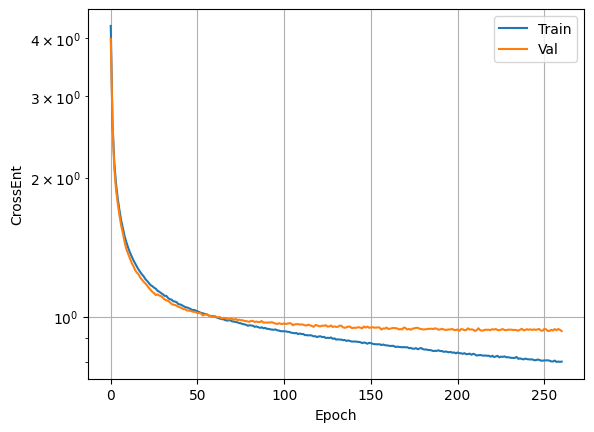

In [23]:
plot_losses(train_losses, val_losses, log=True)

The Leaderboard reports the average performance and the standard deviation across 10 trials.  This will evaluate whether your model's performance is within 1 standard deviation of the mean (expected to happen in 68% of cases if your model has the same performance as the leaderboard).  It will report your performance as "Worse" if it's less than $\mu - \sigma$ and "Better" if it's greater than $\mu + \sigma$ (where $\mu$ is the average and $\sigma$ is the standard deviation).  Even if your performance is identical, this will be wrong in ~32% of cases, so try a few times if it's close, or consider the $\pm 2\sigma$ range instead for 95% confidence.

In [24]:
_ = characterize_performance(model, g, labels, split_idx, evaluator, gcn_path, verbose=True)

Leaderboard:  Test Acc=0.7174 +/- 0.0029, Val Acc=0.73 +/- 0.0017
Yours:        Test Acc=0.7218,            Val Acc=0.7293

Validation performance is in the expected range of 0.7283 - 0.7317.
Test performance is better than LB.  Expected upper bound of 0.7203, but got 0.7218.


#### Collect statistics
To properly assess the quality of our model, we'll need to run several times and compare the performance distribution.  Since this is time consuming, *only run this once you're getting reasonable results from single runs.*

In [25]:
df_gcn = get_experiment_stats(
    model_cls=GCN, model_args=model_kwargs,
    train_args=train_args, n_experiments=10
)

Starting training for experiment 1
Early stopping at 370 epochs
Leaderboard:  Test Acc=0.7174 +/- 0.0029, Val Acc=0.73 +/- 0.0017
Yours:        Test Acc=0.7250,            Val Acc=0.7330

Training complete

Starting training for experiment 2
Early stopping at 480 epochs
Leaderboard:  Test Acc=0.7174 +/- 0.0029, Val Acc=0.73 +/- 0.0017
Yours:        Test Acc=0.7169,            Val Acc=0.7322

Training complete

Starting training for experiment 3
Early stopping at 280 epochs
Leaderboard:  Test Acc=0.7174 +/- 0.0029, Val Acc=0.73 +/- 0.0017
Yours:        Test Acc=0.7166,            Val Acc=0.7290

Training complete

Starting training for experiment 4


KeyboardInterrupt: 

In [ ]:
norm_plot(
    [
        (test_acc_lb, test_acc_lb_var, 'Leaderboard'), 
        (df_gcn.loc['mean', 'test_acc'], df_gcn.loc['std', 'test_acc'], 'GCN'),
    ],
    'Test Performance'
)

In [ ]:
# Conduct a Welch's t-test to determine if the means are different with statistical significance 
_, p = stats.ttest_ind_from_stats(
    test_acc_lb, test_acc_lb_var, 10,
    df_gcn.loc['mean', 'test_acc'], df_gcn.loc['std', 'test_acc'], 10,
    equal_var=False,
)
print(f"Mean Test Accuracy Improvement: {(df_gcn.loc['mean', 'test_acc'] - test_acc_lb):.4f}")
print(f"Probability that these are from the same performance distribution = {p*100:.0f}%")

# Improvements
Now that we can match the GCN performance from the Leaderboard we can go about improving upon it.  In this section, we will implement a few ideas from the ["Bag of Tricks"](https://arxiv.org/abs/2103.13355) paper.  Specifically, we will implement:

1. The "Loge" loss function they propose
2. Linear projected skip connections + Input Dropout (also with Loge loss)

These changes should result in climbing several positions up the Leaderboard.  

In [ ]:
def loge(x, labels):
    """
    The "Loge" loss function described in the paper.  Should take the same inputs
    as the `F.cross_entropy` functional of torch.
    
    Use `epsilon = 1 - math.log(2)` and take the average across the batch

    Args:
        x (Tensor): the model predictions
        labels (Tensor): node labels
        
    Returns:
        The average Loge loss across the batch
    """
    # TODO
    # Implement the Loge loss function described in the paper
    pass

In [ ]:
model_loge_kwargs = dict(
    # TODO: Add your parameter values
)
model_loge = GCN(**model_loge_kwargs).to(device)

In [ ]:
gcn_loge_path = f"{model_path}/gcn_loge.model"

In [ ]:
train_loge_args = dict(
    g=g, labels=labels, split_idx=split_idx, 
    epochs=500, evaluator=evaluator, device=device, 
    save_path=gcn_loge_path, lr=5e-3, es_criteria=50,
    loss_fn=loge # this changes the loss function to use "loge"
)

In [ ]:
train_losses, val_losses = train(model=model_loge, verbose=True, **train_loge_args)

In [ ]:
plot_losses(train_losses, val_losses, log=True)

In [ ]:
_ = characterize_performance(model_loge, g, labels, split_idx, evaluator, gcn_loge_path, verbose=True)

#### Collect statistics

In [ ]:
df_loge = get_experiment_stats(
    model_cls=GCN, model_args=model_loge_kwargs,
    train_args=train_loge_args, n_experiments=10
)

In [ ]:
norm_plot(
    [
        (test_acc_lb, test_acc_lb_var, 'Leaderboard'), 
        (df_gcn.loc['mean', 'test_acc'], df_gcn.loc['std', 'test_acc'], 'GCN'),
        (df_loge.loc['mean', 'test_acc'], df_loge.loc['std', 'test_acc'], 'Loge Loss Func'),
    ],
    'Test Performance'
)

In [ ]:
# Conduct a Welch's t-test to determine if the means are different with statistical significance 
_, p = stats.ttest_ind_from_stats(
    test_acc_lb, test_acc_lb_var, 10,
    df_loge.loc['mean', 'test_acc'], df_loge.loc['std', 'test_acc'], 10,
    equal_var=False,
)
print(f"Mean Test Accuracy Improvement: {(df_loge.loc['mean', 'test_acc'] - test_acc_lb):.4f}")
print(f"Probability that these are from the same performance distribution = {p*100:.0f}%")

## Linear skip connections + Input Dropout
Here we will implement a skip connection that adds (a linear transformation of) 
the input to the output of the Graph Convolution layer.  Additionally, we will 
add Dropout to the raw input features.

### Details
There are several choices to make during implementation, and here I'll describe
some of mine to enable reproducibility.  Feel free to experiment, as other 
choices may improve performance.

Let's call the input node features $X$.  First, we apply dropout: 
$X_d = \text{Dropout}(X)$.  Next, we have two terms to calculate: 
1. A linear projection of the input: $X_\text{linear} = W * X_d$
2. A GCN output: $X_\text{GCN} = \text{GraphConv}(g, X_d)$

Next, we add these terms to get the skip connection: 
$Z = X_\text{linear} + X_\text{GCN}$.  In other words, we apply a normal NN 
layer and a GCN layer in parallel, and then add the results. This let's the raw 
feature signal pass through and not get lost by doing the neighborhood 
averaging operation of GCN.

For hidden layers, this output is finally passed through a stack of BatchNorm, 
ReLU activation and Dropout:  
$$H = \text{Dropout}(\text{ReLU}(\text{BatchNorm}(Z))).$$

There is some debate on the proper order of these operations--feel free to 
experiment.  *Note that for the last layer, no dropout, ReLU, or BatchNorm is 
applied.*

#### Bias terms
In the above, I exclude bias terms from the Linear and GCN layers, but 
either could include them (e.g., $X_\text{linear} = W * X_d + b$).  In my case, 
**I only use a bias in the last layer**.  (If you do something different, the 
assertion below for number of model parameters will fail.)  This is because 
there is likely to be a 
class imbalance, and a final additive bias term can be learned to match the 
overall class balance, and therefore free up the remaining model parameters to 
not have to worry about that. 

To be clear, you could make _either_ the linear or GCN layer have the bias, and 
the results would be the same. Both are equivalent to writing 
$Z = X_\text{linear} + X_\text{GCN} + b$, and it's inconsequential whether you 
consider $b$ to be part of the linear or GCN layer (but it's pointless to do 
both).  To summarize, you can match my architecture and get the same number of 
model parameters by doing the following:
- Set `bias=False` in all hidden linear and GCN layers.  Use the `Z -> BatchNorm -> ReLU -> Dropout` stack.
- Set `bias=True` for either the last linear layer, or last GCN layer, but not both.  No BatchNorm/ReLU/Dropout operations.

In [ ]:
class GCNwLinear(nn.Module):
    def __init__(self, ): # TODO: add your arguments
        
        super(GCNwLinear, self).__init__()
        # TODO 
        """
        In addition to GCN from before, create the linear layers to operate on the 
        input of each GraphConv layer.  As before, also create Batch Norm layers for 
        all GraphConv layers *except the last one*.
        
        All layers except the last should support Dropout.  
        
        For the *input dropout*, it should be as follows:
            `self.input_drop = nn.Dropout(min(0.1, dropout))`
            
        which means that while the network layers can have any value of Dropout, the input
        features never receive more than 0.1 dropout rate.
        
        To re-create my results, only use a bias in *last* GraphConv layer
        and none of the linear layers or earlier GraphConv layers.
        """
        # TODO
        
        
        # Input layer: dropout, Linear, GraphConv, BatchNorm
        
        
        # Hidden layers: dropout, Linear, GraphConv, BatchNorm
        
        
        # Output layer: GraphConv, Linear
        
        pass

    def forward(self, g, in_feat):
        """
        The forward pass of the model, which applies all of the layers
        to a given graph and set of node features
        
        Args:
            g (DGLGraph): the graph used for Graph Convolutions
            in_feat (Tensor): the node features
            
        Returns:
            the logits of the model as a Tensor, in which *no final activation function
            has been applied*.
        """
        # TODO 
        pass

In [ ]:
model_linear_kwargs = dict(
    # TODO: Add your parameter values
)
model_linear = GCNwLinear(**model_linear_kwargs).to(device)

In [ ]:
# If this fails, the number of parameters in your model doesn't match mine (assuming 3 graphconv layers)
linear_parms = 218152
model_linear_parms = sum(p.numel() for p in model_linear.parameters() if p.requires_grad)
assert linear_parms == model_linear_parms, "Number of model parameters different than Leaderboard's"

In [ ]:
gcn_linear_path = f"{model_path}/gcn_linear.model"

In [ ]:
train_linear_args = dict(
    g=g, labels=labels, split_idx=split_idx, 
    epochs=500, evaluator=evaluator, device=device, 
    save_path=gcn_linear_path, lr=5e-3, es_criteria=50,
    loss_fn=loge
)

In [ ]:
train_losses, val_losses = train(model=model_linear, verbose=True, **train_linear_args)

In [ ]:
plot_losses(train_losses, val_losses, log=True)

In [ ]:
_ = characterize_performance(model_linear, g, labels, split_idx, evaluator, gcn_linear_path, verbose=True)

### Stats
Do this for 10 iterations to get some statistics

In [ ]:
df_linear = get_experiment_stats(
    model_cls=GCNwLinear, model_args=model_linear_kwargs,
    train_args=train_linear_args, n_experiments=10
)

In [ ]:
norm_plot(
    [
        (test_acc_lb, test_acc_lb_var, 'Leaderboard'), 
        (df_gcn.loc['mean', 'test_acc'], df_gcn.loc['std', 'test_acc'], 'GCN'),
        (df_loge.loc['mean', 'test_acc'], df_loge.loc['std', 'test_acc'], 'Loge Loss Func'), 
        (df_linear.loc['mean', 'test_acc'], df_linear.loc['std', 'test_acc'], 'Linear Skip'),
    ],
    'Test Performance'
)

In [ ]:
_, p = stats.ttest_ind_from_stats(
    test_acc_lb, test_acc_lb_var, 10,
    df_linear.loc['mean', 'test_acc'], df_linear.loc['std', 'test_acc'], 10,
    equal_var=False, #alternative='two-sided',
)
print(f"Mean Test Accuracy Improvement: {(df_linear.loc['mean', 'test_acc'] - test_acc_lb):.4f}")
print(f"Probability that these are the same = {p*100:.0f}%")

### Results summary
Although your results might be different, I achieve a mean Test performance of 0.7231 +/- 0.0031.  As of the time of writing, GCN is at position 39 on the leaderboard, but we would be placed at position 30 with these improvements.  The authors of the "Bag of Tricks" paper are in position 23 with mean Test performance of 0.7306.

# Extra Credit
There are at least two paths you can take:  

## More "Bag of Tricks" improvements
We implemented the "Loge" loss function and added the "Linear + Skip Connections" component, but there are many other tweaks presented in the paper, some of which are already on the leaderboard and demonstrate significant gains.  Some specific ideas:
- Implement "Label as input", where the training set is randomly split such that half the nodes use a one-hot-encoding of the label as an input feature and the other half use dummy values of zeros.  This is an attempt to bring the benefits of Label Propagation to GNNs
- Implement "Label reuse", where instead of using dummy values for half of the training data's "label features", you instead use model predictions from the previous iteration (i.e., "soft labels")
- Switch from GCN layers to Graph Attention Networks (GAT) and implement the tricks presented in the paper, like using the symmetric normalized adjacency matrix

## Find another paper
The Leaderboard contains a wide variety of approaches, all with linked papers and code.  Look around and choose one that's interesting.  For example, many top positions as of this writing appear to use self-Knowledge Distillation ("self-KD"), so this may be worth exploring.

In [ ]:
# TODO